In [ ]:
%pip install contextily
%pip install folium
%pip install matplotlib

In [10]:
import math
import pickle
import random
from collections import defaultdict

import contextily as ctx
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

#########################################
# Helper Functions
#########################################
DATA_PATH = "../datasets"
NUM_PATHS = 10_000

def haversine(lon1, lat1, lon2, lat2):
    """Calculate the Haversine distance (in kilometers) between two points."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    return c * 6371  # Earth radius in km

def heuristic_state(state, goal, stops_dict):
    """
    Heuristic for A*: Haversine distance between the stops in state and goal.
    state, goal: Tuple (stop_id, line)
    stops_dict: Dictionary mapping stop_id to (lon, lat)
    """
    stop1, stop2 = state[0], goal[0]
    lon1, lat1 = stops_dict[stop1]
    lon2, lat2 = stops_dict[stop2]
    return haversine(lon1, lat1, lon2, lat2)

#########################################
# 1. Load GTFS Files and Filter Stops by Name (only stops with "Berlin" in stop_name)
#########################################
stops = pd.read_csv("berlin_gtfs/stops.txt", low_memory=False)       # Contains stop_id, stop_name, stop_lat, stop_lon, parent_station, etc.
routes = pd.read_csv("berlin_gtfs/routes.txt", low_memory=False)     # Contains route_id, route_short_name, etc.
trips = pd.read_csv("berlin_gtfs/trips.txt", low_memory=False)       # Contains trip_id, route_id, etc.
stop_times = pd.read_csv("berlin_gtfs/stop_times.txt", low_memory=False)  # Contains trip_id, stop_id, stop_sequence, etc.

# Filter stops: only keep stops where "Berlin" appears in stop_name (case_insensitive)
berlin_stops = stops[stops['stop_name'].str.contains("Berlin", na=False, case=False)].copy()
print(f"Number of stops with 'Berlin' in their name: {len(berlin_stops)}")

# Create a set of stop_ids from the filtered stops
berlin_stop_ids = set(berlin_stops['stop_id'])

# Filter stop_times to include only stops in our filtered set
stop_times = stop_times[stop_times['stop_id'].isin(berlin_stop_ids)]

# Merge trips with routes to obtain line information (e.g. route_short_name)
trips = trips.merge(routes[['route_id', 'route_short_name']], on="route_id", how="left")

# Merge stop_times with trips to attach line information to each record and sort by trip and sequence
stop_times = stop_times.merge(trips[['trip_id', 'route_short_name']], on="trip_id", how="left")
stop_times = stop_times.sort_values(by=["trip_id", "stop_sequence"])

#########################################
# 2. Build Base Network (Construct "ride" edges based solely on GTFS connections)
#########################################
edge_lines = defaultdict(set)  # Maps (stop1, stop2) to the set of lines serving that edge
node_lines = defaultdict(set)  # Maps stop to the set of lines that serve it

# Process each trip (with tqdm progress)
for trip_id, group in tqdm(list(stop_times.groupby("trip_id")), desc="Processing Trips"):
    group = group.sort_values("stop_sequence")
    stops_in_trip = group['stop_id'].tolist()
    line = group['route_short_name'].iloc[0]  # All stops in this trip share the same line
    for stop in stops_in_trip:
        node_lines[stop].add(line)
    # Only connect in the given (GTFS) direction
    for i in range(len(stops_in_trip) - 1):
        s1, s2 = stops_in_trip[i], stops_in_trip[i+1]
        edge_lines[(s1, s2)].add(line)

#########################################
# 3. Build the State-Space Graph with Ride-Edges
#########################################
G_state = nx.DiGraph()

# Create nodes as (stop_id, line)
for stop, lines in node_lines.items():
    for line in lines:
        G_state.add_node((stop, line))

# Add directed Ride-Edges based solely on GTFS connections
for (s1, s2), lines in edge_lines.items():
    for line in lines:
        if G_state.has_node((s1, line)) and G_state.has_node((s2, line)):
            # Get coordinates from berlin_stops
            lon1, lat1 = berlin_stops.loc[berlin_stops.stop_id == s1, ['stop_lon', 'stop_lat']].iloc[0]
            lon2, lat2 = berlin_stops.loc[berlin_stops.stop_id == s2, ['stop_lon', 'stop_lat']].iloc[0]
            cost = haversine(float(lon1), float(lat1), float(lon2), float(lat2))
            G_state.add_edge((s1, line), (s2, line), weight=cost, edge_type="ride")

#########################################
# 4. Add Transfer Edges Based on Parent Station Information
#########################################
# Create an effective parent mapping: if a stop has a parent_station, use it;
# otherwise, use the stop_id itself.
parent_map = {}
for idx, row in berlin_stops.iterrows():
    stop_id = row['stop_id']
    parent = row.get('parent_station', None)
    if pd.isna(parent) or parent == "":
        parent_map[stop_id] = stop_id
    else:
        parent_map[stop_id] = parent

# Group state-space nodes by effective parent station
parent_nodes = defaultdict(list)
for node in G_state.nodes():
    stop, line = node
    parent = parent_map.get(stop, stop)
    parent_nodes[parent].append(node)

transfer_cost = 1.0  # Fixed cost for transfers
# Add bidirectional transfer edges only among nodes (stop, line) sharing the same effective parent station.
for parent, nodes in parent_nodes.items():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                u = nodes[i]
                v = nodes[j]
                G_state.add_edge(u, v, weight=transfer_cost, edge_type="transfer")
                G_state.add_edge(v, u, weight=transfer_cost, edge_type="transfer")

#########################################
# 5. A* Search in the State-Space with Random Start and Goal
#########################################
# Build a dictionary mapping stop_id to (lon, lat)
stops_dict = {row['stop_id']: (float(row['stop_lon']), float(row['stop_lat'])) 
              for idx, row in berlin_stops.iterrows()}
station_names_map = dict(zip(berlin_stops['stop_id'], berlin_stops['stop_name']))

def compute_astar_path(G_state, start_state, goal_state):
    """Compute the A* path from start_state to goal_state in the state-space graph."""
    try:
        return nx.astar_path(
            G_state, start_state, goal_state,
            heuristic=lambda u, v: heuristic_state(u, v, stops_dict),
            weight="weight"
        )
    except nx.NetworkXNoPath:
        return None

# Aggregate ride-edge usage over many random A* path computations.
ride_edge_counts = defaultdict(int)

all_paths = list()
for i in tqdm(range(NUM_PATHS), desc="Computing A* Paths"):
    start_stop = np.random.choice(list(berlin_stop_ids))
    end_stop = np.random.choice(list(berlin_stop_ids))
    while end_stop == start_stop:
        end_stop = np.random.choice(list(berlin_stop_ids))
        
    start_lines = list(node_lines[start_stop])
    end_lines = list(node_lines[end_stop])
    if not start_lines or not end_lines:
        continue  # Skip if no line is available
    
    start_state = (start_stop, np.random.choice(start_lines))
    goal_state = (end_stop, np.random.choice(end_lines))
    
    path = compute_astar_path(G_state, start_state, goal_state)
    if path is None:
        continue
    
    path_station_names = np.array([station_names_map[node[0]] for node in path])
    # Remove consecutive duplicates using a boolean mask (if path is not empty)
    if path_station_names.size > 0:
        mask = np.concatenate(([True], path_station_names[1:] != path_station_names[:-1]))
        cleaned_path = path_station_names[mask]
        all_paths.append(cleaned_path)

    # all_paths.append(cleaned_path)

    # Count each ride edge used (direction matters)
    for j in range(len(path) - 1):
        u, v = path[j], path[j+1]
        edge_data = G_state.get_edge_data(u, v)
        if edge_data and edge_data.get("edge_type") == "ride":
            ride_edge_counts[(u[0], v[0])] += 1

# Save Paths to Pickle File
with open(f'{DATA_PATH}/paths.pkl', 'wb') as f:
    pickle.dump(all_paths, f)
print(f"Saved {len(all_paths)} paths to paths.pkl")

#########################################
# 6. Plot Heatmap of the Base Network
#########################################
mean_lat = berlin_stops['stop_lat'].astype(float).mean()
mean_lon = berlin_stops['stop_lon'].astype(float).mean()

# Create a Folium Map centered on Berlin with a high-quality base map (e.g., CartoDB positron)
# m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12, tiles='CartoDB Voyager', control_scale=True)

G_base = nx.Graph()

# Add all filtered stops as nodes with positions.
for idx, row in berlin_stops.iterrows():
    G_base.add_node(row['stop_id'], pos=(float(row['stop_lon']), float(row['stop_lat'])), name=row.get('stop_name', ""))

# Add edges from aggregated ride_edge_counts.
for (s1, s2), count in ride_edge_counts.items():
    lon1, lat1 = stops_dict[s1]
    lon2, lat2 = stops_dict[s2]
    dist = haversine(lon1, lat1, lon2, lat2)
    # For visualization, use an undirected edge.
    G_base.add_edge(s1, s2, weight=dist, count=count)

# Remove isolated nodes (stations with no connection)
isolated_nodes = list(nx.isolates(G_base))
if isolated_nodes:
    print("Removing isolated nodes")
    G_base.remove_nodes_from(isolated_nodes)

# Prepare visualization: color and width based on usage.
edges = list(G_base.edges())
counts = np.array([G_base[u][v].get("count", 0) for u, v in edges])
norm_counts = counts / counts.max() if counts.max() > 0 else counts

# Custom colormap from dark orange to deep red
colors = [
    #"#e5f5e0",  # very light green
    # "#a1d99b",  # light green
    "#4c5ced",
    # "#fee08b",  # pale yellow
    # "#fc8d59",  # light coral/red
    # "#fd8d3c",  # light orange
    "#f16913",  # medium orange
    "#e6550d",  # dark orange
    "#e31a1c",  # strong red
    "#99000d"   # deep red
]
cmap = LinearSegmentedColormap.from_list("orange_red", colors)
edge_colors = [cmap(norm) for norm in norm_counts]
min_width, max_width = 0.5, 5
edge_widths = min_width + (max_width - min_width) * norm_counts

pos = nx.get_node_attributes(G_base, 'pos')

# 1) Bigger network plot
fig1, ax1 = plt.subplots(figsize=(26, 26))   # ← increase figsize
nx.draw_networkx_edges(
    G_base, pos,
    edge_color=edge_colors,
    width=edge_widths,
    ax=ax1
)
# ax1.set_title(
#     "Heatmap: Uniformly Sampled A* Paths",
#     fontsize=28   # you can scale this up/down as you like
# )
ax1.axis("off")
fig1.savefig(
    "/home/max/Latex/M.Sc. Thesis Max Schulze/Graphics/Approach/Simulation/heatmap_no_hotspots.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.close(fig1)


# 2) Slimmer standalone colorbar
#    Here we make the figure very short in height
fig2, ax2 = plt.subplots(figsize=(6, 0.2))   # ← shrink height
sm = cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=counts.min(), vmax=counts.max())
)
sm.set_array([])
cbar = fig2.colorbar(sm, cax=ax2, orientation="horizontal")
cbar.set_label(
    "Usage (Number of Paths)",
    fontsize=8, labelpad=0.5
)
# Hide the y‐axis entirely, leave ticks below
ax2.tick_params(axis='x', labelsize=8)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_visible(False)
plt.savefig(
    "/home/max/Latex/M.Sc. Thesis Max Schulze/Graphics/Approach/Simulation/heatmap_colorbar_only.pdf",
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1
)
plt.close(fig2)

# Add each edge from G_base as a polyline on the interactive map
# (Convert coordinates from (lon, lat) to (lat, lon) for Folium)
# Pre-compute maximum usage to scale weights
max_usage = max([d.get("count", 1) for _, _, d in G_base.edges(data=True)])

# for (s1, s2, data) in G_base.edges(data=True):
#     # Get coordinates and swap to (lat, lon)
#     lat1, lon1 = stops_dict[s1][1], stops_dict[s1][0]
#     lat2, lon2 = stops_dict[s2][1], stops_dict[s2][0]
    
#     usage = data.get("count", 1)
#     # Scale the line weight based on usage (optional customization)
#     weight = 2 + (usage / max_usage) * 4

#     # Compute normalized usage and get the corresponding color from "OrRd"
#     norm_usage = usage / max_usage
#     rgba_color = cmap(norm_usage)
#     hex_color = mcolors.to_hex(rgba_color)
    
#     folium.PolyLine(
#         locations=[(lat1, lon1), (lat2, lon2)],
#         weight=weight,
#         color=hex_color,
#         opacity=0.85
#     ).add_to(m)

# Save the interactive map as an HTML file
# m.save("index.html")
print("Interactive heatmap saved as index.html")


Number of stops with 'Berlin' in their name: 19273


Computing A* Paths: 100%|██████████| 10000/10000 [02:17<00:00, 72.89it/s]


Saved 1472 paths to paths.pkl
Removing isolated nodes
Interactive heatmap saved as index.html


Number of stops with 'Berlin' in their name: 19273


Processing Trips: 100%|██████████| 200348/200348 [01:31<00:00, 2184.38it/s]


Selected 17 reachable hotspots: 10 central, 7 outliers


Computing A* Paths: 100%|██████████| 10000/10000 [02:34<00:00, 64.53it/s]


Saved 3492 paths to paths.pkl
Removing isolated nodes


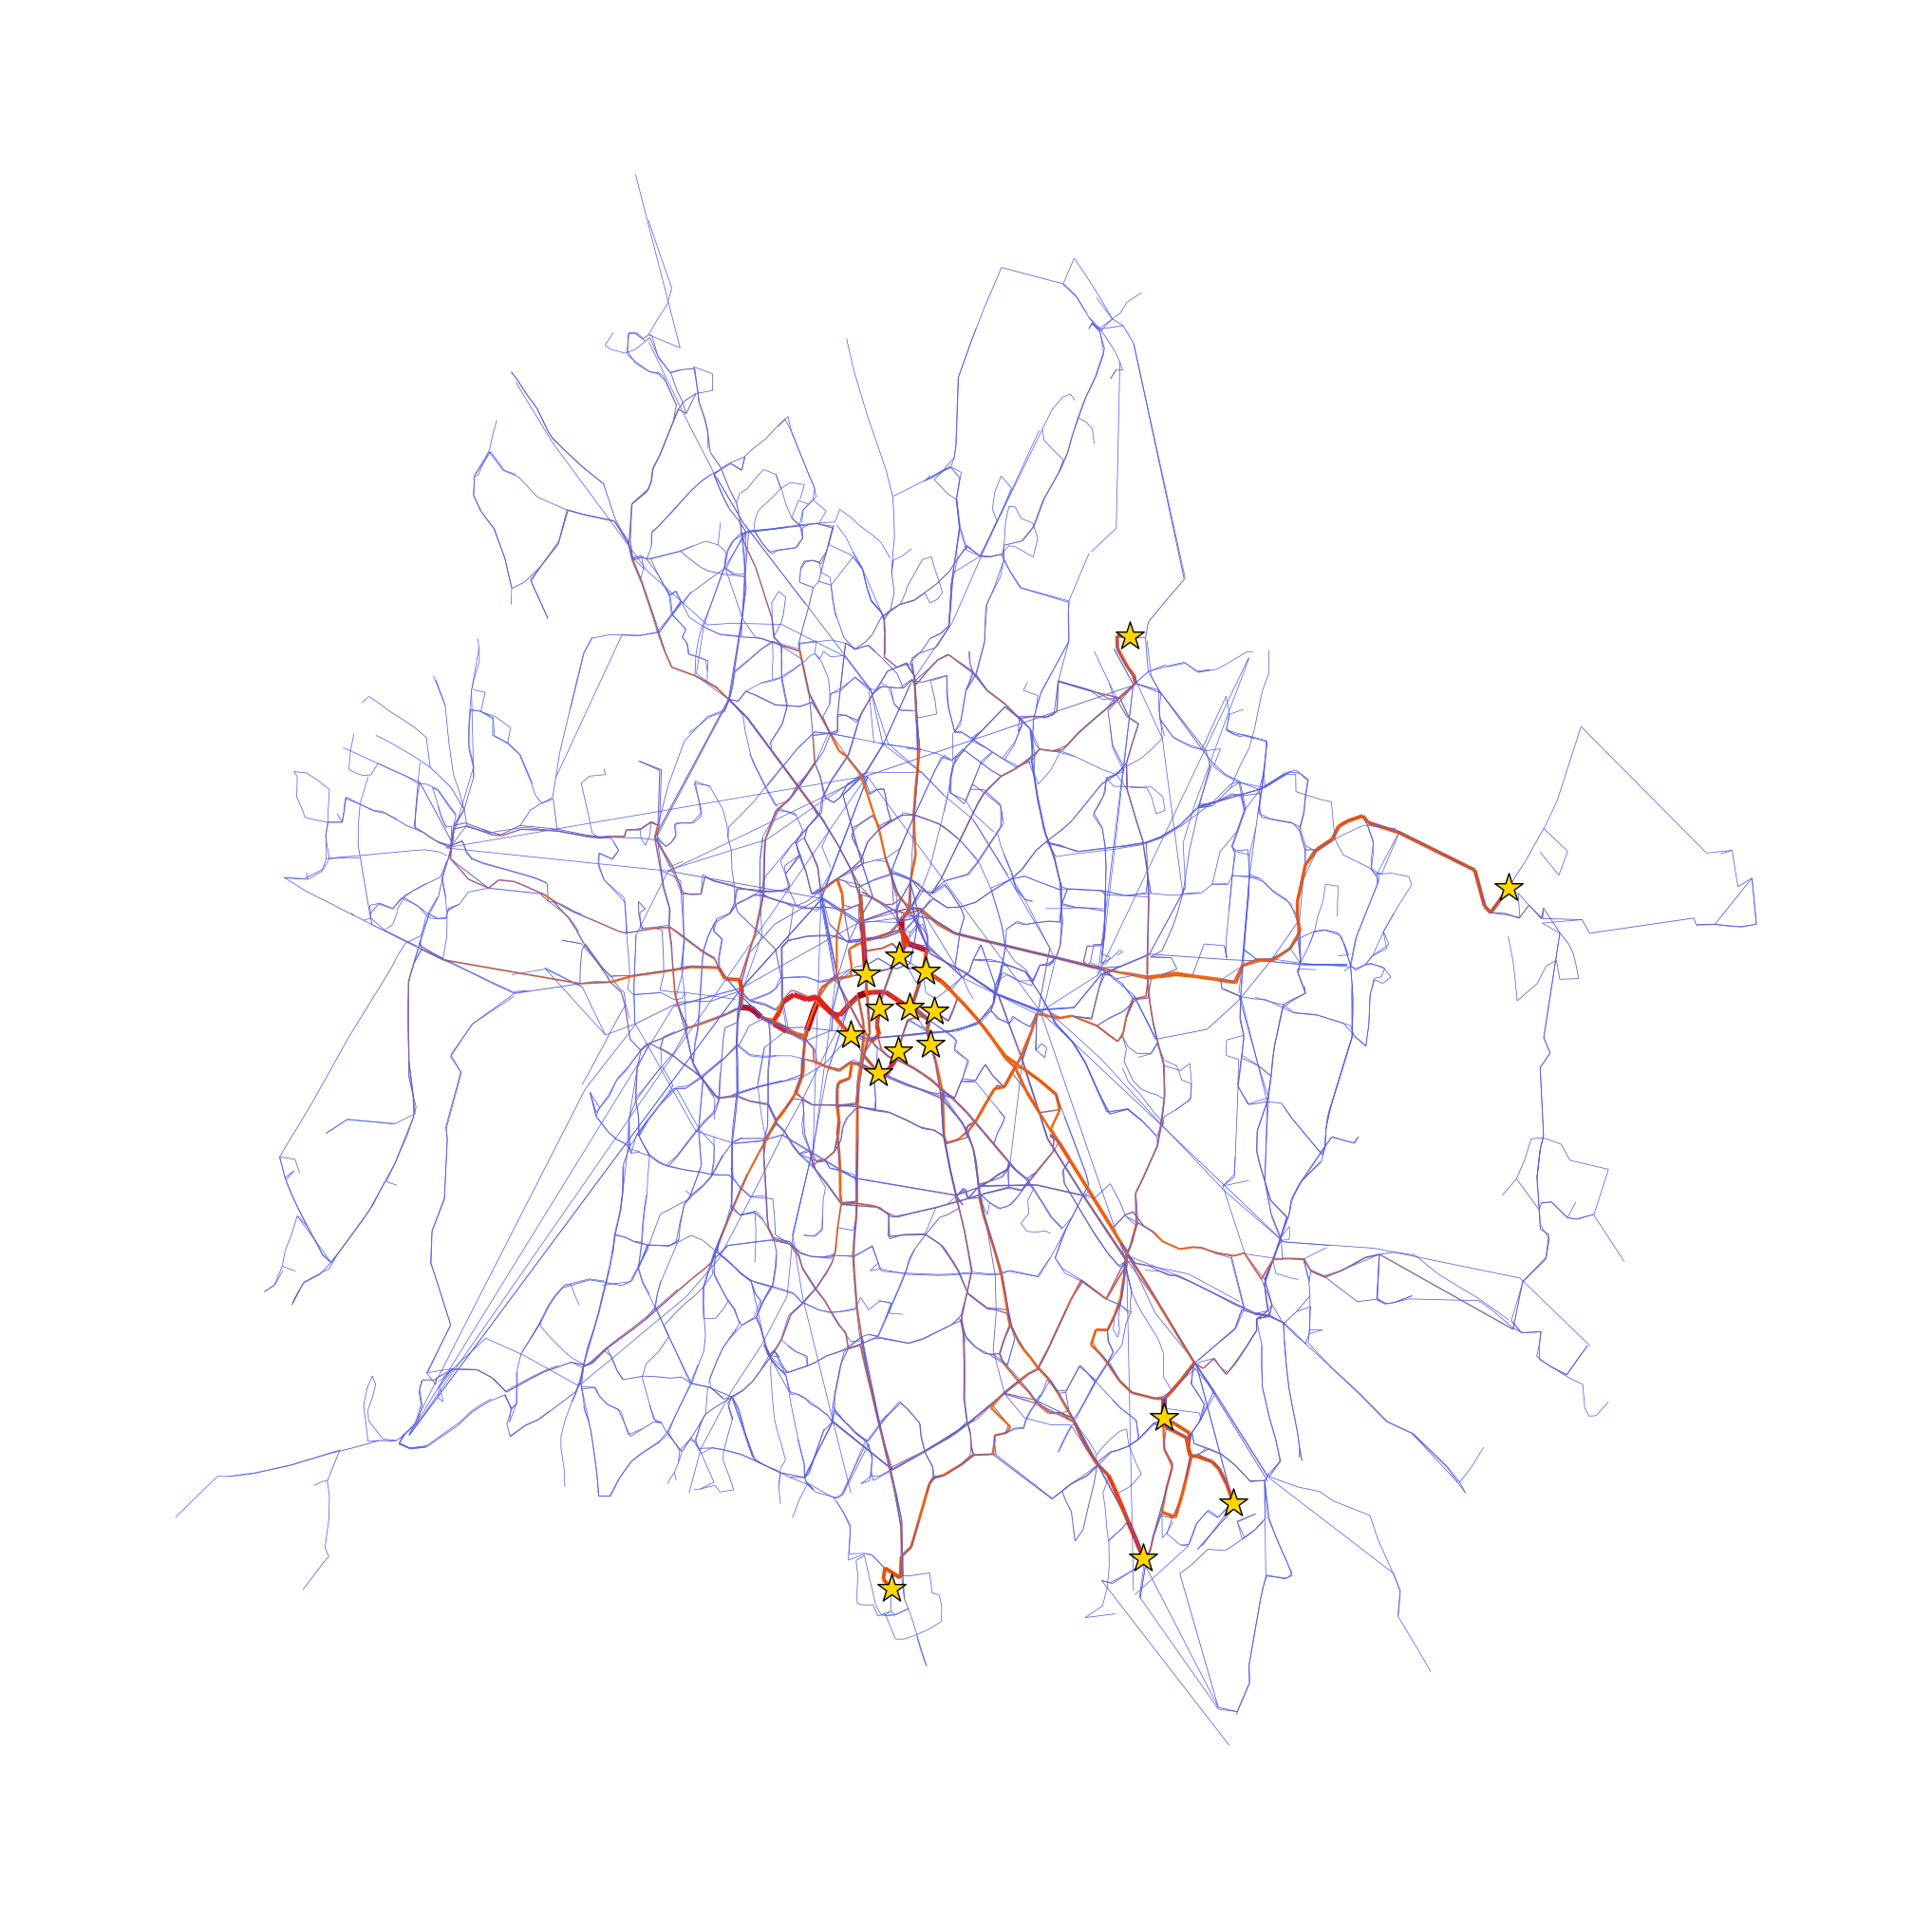

ValueError: Custom tiles must have an attribution.

In [3]:
import math
import pickle
import random
from collections import defaultdict

import contextily as ctx
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

#########################################
# Helper Functions
#########################################
DATA_PATH = "../datasets"
NUM_PATHS = 10_000

def haversine(lon1, lat1, lon2, lat2):
    """Calculate the Haversine distance (in kilometers) between two points."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    return c * 6371  # Earth radius in km

def heuristic_state(state, goal, stops_dict):
    """
    Heuristic for A*: Haversine distance between the stops in state and goal.
    state, goal: Tuple (stop_id, line)
    stops_dict: Dictionary mapping stop_id to (lon, lat)
    """
    stop1, stop2 = state[0], goal[0]
    lon1, lat1 = stops_dict[stop1]
    lon2, lat2 = stops_dict[stop2]
    return haversine(lon1, lat1, lon2, lat2)

#########################################
# 1. Load GTFS Files and Filter Stops by Name (only stops with "Berlin" in stop_name)
#########################################
stops = pd.read_csv("berlin_gtfs/stops.txt", low_memory=False)       # Contains stop_id, stop_name, stop_lat, stop_lon, parent_station, etc.
routes = pd.read_csv("berlin_gtfs/routes.txt", low_memory=False)     # Contains route_id, route_short_name, etc.
trips = pd.read_csv("berlin_gtfs/trips.txt", low_memory=False)       # Contains trip_id, route_id, etc.
stop_times = pd.read_csv("berlin_gtfs/stop_times.txt", low_memory=False)  # Contains trip_id, stop_id, stop_sequence, etc.

# Filter stops: only keep stops where "Berlin" appears in stop_name (case_insensitive)
berlin_stops = stops[stops['stop_name'].str.contains("Berlin", na=False, case=False)].copy()
print(f"Number of stops with 'Berlin' in their name: {len(berlin_stops)}")

# Create a set of stop_ids from the filtered stops
berlin_stop_ids = set(berlin_stops['stop_id'])

# Filter stop_times to include only stops in our filtered set
stop_times = stop_times[stop_times['stop_id'].isin(berlin_stop_ids)]

# Merge trips with routes to obtain line information (e.g. route_short_name)
trips = trips.merge(routes[['route_id', 'route_short_name']], on="route_id", how="left")

# Merge stop_times with trips to attach line information to each record and sort by trip and sequence
stop_times = stop_times.merge(trips[['trip_id', 'route_short_name']], on="trip_id", how="left")
stop_times = stop_times.sort_values(by=["trip_id", "stop_sequence"])

# Build ride-edge info for reachability
edge_lines = defaultdict(set)
node_lines = defaultdict(set)
for trip_id, group in tqdm(stop_times.groupby("trip_id"), desc="Processing Trips"):
    group = group.sort_values("stop_sequence")
    stops_in_trip = group['stop_id'].tolist()
    line = group['route_short_name'].iloc[0]
    for stop in stops_in_trip:
        node_lines[stop].add(line)
    for i in range(len(stops_in_trip) - 1):
        s1, s2 = stops_in_trip[i], stops_in_trip[i+1]
        edge_lines[(s1, s2)].add(line)

# Determine which stops are reachable via at least one ride-edge
reachable_stop_ids = {s for edge in edge_lines.keys() for s in edge}

#########################################
# 2. Define Hotspots: ensure only reachable
#########################################
# Bounding box for Berlin region
lat_min, lat_max = 52.3, 52.7
lon_min, lon_max = 13.0, 13.8

# Convert coordinates to float
berlin_stops['stop_lat'] = berlin_stops['stop_lat'].astype(float)
berlin_stops['stop_lon'] = berlin_stops['stop_lon'].astype(float)

# Filter to region and reachable
all_stop_ids = berlin_stops[
    berlin_stops['stop_lat'].between(lat_min, lat_max) &
    berlin_stops['stop_lon'].between(lon_min, lon_max) &
    berlin_stops['stop_id'].isin(reachable_stop_ids)
].copy()

# Compute distance to center
center_lat = all_stop_ids['stop_lat'].mean()
center_lon = all_stop_ids['stop_lon'].mean()
def dist_to_center(row):
    return haversine(row['stop_lon'], row['stop_lat'], center_lon, center_lat)
all_stop_ids['dist_to_center'] = all_stop_ids.apply(dist_to_center, axis=1)

# Function to sample points with a minimum mutual distance
def sample_with_min_distance(candidates, coords_dict, n_samples, min_dist_km):
    selected = []
    random.shuffle(candidates)
    for sid in candidates:
        if len(selected) >= n_samples:
            break
        lon1, lat1 = coords_dict[sid]
        # check distance to all already selected
        if all(haversine(lon1, lat1, *coords_dict[other]) >= min_dist_km for other in selected):
            selected.append(sid)
    return selected

# Prepare coordinate lookup for stops
coords = {row['stop_id']: (row['stop_lon'], row['stop_lat']) for _, row in all_stop_ids.iterrows()}

# Sample hotspots from reachable region stops
num_hotspots = random.randint(15, 30)
n_central = int(num_hotspots * 0.7)
n_outliers = num_hotspots - n_central

# Candidates sorted by proximity to center
stops_sorted = all_stop_ids.sort_values('dist_to_center')
central_candidates = stops_sorted.head(n_central * 12)['stop_id'].tolist()
outlier_candidates = stops_sorted.tail(int(len(stops_sorted) * 0.4))['stop_id'].tolist()

# Ensure enough candidates and sample without replacement
# Enforce a minimum distance (e.g., 0.5 km) among central hotspots
MIN_CENTRAL_DIST_KM = 0.7
central_hotspots = sample_with_min_distance(
    central_candidates, coords, n_central, MIN_CENTRAL_DIST_KM
)
# central_hotspots = random.sample(
#     [s for s in central_candidates if s in reachable_stop_ids],
#     min(n_central, len(central_candidates))
# )
outlier_hotspots = random.sample(
    [s for s in outlier_candidates if s in reachable_stop_ids],
    min(n_outliers, len(outlier_candidates))
)
hotspots = set(central_hotspots + outlier_hotspots)
print(f"Selected {len(hotspots)} reachable hotspots: {len(central_hotspots)} central, {len(outlier_hotspots)} outliers")

# Build sampling weights for end stops
end_stops = berlin_stops['stop_id'].tolist()
n_total = len(end_stops)
n_hot = len(hotspots)
n_non = n_total - n_hot
base_w = 1.0
hot_w = (n_non / n_hot) + base_w if n_hot > 0 else base_w
weights = [hot_w if sid in hotspots else base_w for sid in end_stops]
probabilities = np.array(weights) / np.sum(weights)
probabilities = probabilities.flatten()

#########################################
# 2. Build Base Network (Construct "ride" edges based solely on GTFS connections)
#########################################
edge_lines = defaultdict(set)  # Maps (stop1, stop2) to the set of lines serving that edge
node_lines = defaultdict(set)  # Maps stop to the set of lines that serve it

# Process each trip (with tqdm progress)
for trip_id, group in tqdm(list(stop_times.groupby("trip_id")), desc="Processing Trips"):
    group = group.sort_values("stop_sequence")
    stops_in_trip = group['stop_id'].tolist()
    line = group['route_short_name'].iloc[0]  # All stops in this trip share the same line
    for stop in stops_in_trip:
        node_lines[stop].add(line)
    # Only connect in the given (GTFS) direction
    for i in range(len(stops_in_trip) - 1):
        s1, s2 = stops_in_trip[i], stops_in_trip[i+1]
        edge_lines[(s1, s2)].add(line)

#########################################
# 3. Build the State-Space Graph with Ride-Edges
#########################################
G_state = nx.DiGraph()

# Create nodes as (stop_id, line)
for stop, lines in node_lines.items():
    for line in lines:
        G_state.add_node((stop, line))

# Add directed Ride-Edges based solely on GTFS connections
for (s1, s2), lines in edge_lines.items():
    for line in lines:
        if G_state.has_node((s1, line)) and G_state.has_node((s2, line)):
            # Get coordinates from berlin_stops
            lon1, lat1 = berlin_stops.loc[berlin_stops.stop_id == s1, ['stop_lon', 'stop_lat']].iloc[0]
            lon2, lat2 = berlin_stops.loc[berlin_stops.stop_id == s2, ['stop_lon', 'stop_lat']].iloc[0]
            cost = haversine(float(lon1), float(lat1), float(lon2), float(lat2))
            G_state.add_edge((s1, line), (s2, line), weight=cost, edge_type="ride")

#########################################
# 4. Add Transfer Edges Based on Parent Station Information
#########################################
# Create an effective parent mapping: if a stop has a parent_station, use it;
# otherwise, use the stop_id itself.
parent_map = {}
for idx, row in berlin_stops.iterrows():
    stop_id = row['stop_id']
    parent = row.get('parent_station', None)
    if pd.isna(parent) or parent == "":
        parent_map[stop_id] = stop_id
    else:
        parent_map[stop_id] = parent

# Group state-space nodes by effective parent station
parent_nodes = defaultdict(list)
for node in G_state.nodes():
    stop, line = node
    parent = parent_map.get(stop, stop)
    parent_nodes[parent].append(node)

transfer_cost = 1.0  # Fixed cost for transfers
# Add bidirectional transfer edges only among nodes (stop, line) sharing the same effective parent station.
for parent, nodes in parent_nodes.items():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                u = nodes[i]
                v = nodes[j]
                G_state.add_edge(u, v, weight=transfer_cost, edge_type="transfer")
                G_state.add_edge(v, u, weight=transfer_cost, edge_type="transfer")

#########################################
# 5. A* Search in the State-Space with Random Start and Goal
#########################################
# Build a dictionary mapping stop_id to (lon, lat)
stops_dict = {row['stop_id']: (float(row['stop_lon']), float(row['stop_lat'])) 
              for idx, row in berlin_stops.iterrows()}
station_names_map = dict(zip(berlin_stops['stop_id'], berlin_stops['stop_name']))

def compute_astar_path(G_state, start_state, goal_state):
    """Compute the A* path from start_state to goal_state in the state-space graph."""
    try:
        return nx.astar_path(
            G_state, start_state, goal_state,
            heuristic=lambda u, v: heuristic_state(u, v, stops_dict),
            weight="weight"
        )
    except nx.NetworkXNoPath:
        return None

# Aggregate ride-edge usage over many random A* path computations.
ride_edge_counts = defaultdict(int)
all_paths = list()

start_points = set()

for i in tqdm(range(NUM_PATHS), desc="Computing A* Paths"):
    start_stop = np.random.choice(list(berlin_stop_ids))
    start_points.add(start_stop)
    
    # Weighted end stations
    # end_stop = np.random.choice(end_stops, p=probabilities)
    hotspots = list(hotspots)
    end_stop = np.random.choice(hotspots)
    while end_stop == start_stop:
        # end_stop = np.random.choice(end_stops, p=probabilities)
        end_stop = np.random.choice(hotspots)
        
    start_lines = list(node_lines[start_stop])
    end_lines = list(node_lines[end_stop])
    if not start_lines or not end_lines:
        continue  # Skip if no line is available
    
    start_state = (start_stop, np.random.choice(start_lines))
    goal_state = (end_stop, np.random.choice(end_lines))
    
    path = compute_astar_path(G_state, start_state, goal_state)
    if path is None:
        continue
    
    path_station_names = np.array([station_names_map[node[0]] for node in path])
    # Remove consecutive duplicates using a boolean mask (if path is not empty)
    if path_station_names.size > 0:
        mask = np.concatenate(([True], path_station_names[1:] != path_station_names[:-1]))
        cleaned_path = path_station_names[mask]
        all_paths.append(cleaned_path)

    # all_paths.append(cleaned_path)

    # Count each ride edge used (direction matters)
    for j in range(len(path) - 1):
        u, v = path[j], path[j+1]
        edge_data = G_state.get_edge_data(u, v)
        if edge_data and edge_data.get("edge_type") == "ride":
            ride_edge_counts[(u[0], v[0])] += 1

# Save Paths to Pickle File
with open(f'{DATA_PATH}/paths.pkl', 'wb') as f:
    pickle.dump(all_paths, f)
print(f"Saved {len(all_paths)} paths to paths.pkl")

#########################################
# 6. Plot Heatmap of the Base Network
#########################################
mean_lat = berlin_stops['stop_lat'].astype(float).mean()
mean_lon = berlin_stops['stop_lon'].astype(float).mean()

# Create a Folium Map centered on Berlin with a high-quality base map (e.g., CartoDB positron)
# m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12, tiles='CartoDB Voyager', control_scale=True)

G_base = nx.Graph()

# Add all filtered stops as nodes with positions.
for idx, row in berlin_stops.iterrows():
    G_base.add_node(row['stop_id'], pos=(float(row['stop_lon']), float(row['stop_lat'])), name=row.get('stop_name', ""))

# Add edges from aggregated ride_edge_counts.
for (s1, s2), count in ride_edge_counts.items():
    lon1, lat1 = stops_dict[s1]
    lon2, lat2 = stops_dict[s2]
    dist = haversine(lon1, lat1, lon2, lat2)
    # For visualization, use an undirected edge.
    G_base.add_edge(s1, s2, weight=dist, count=count)

# Remove isolated nodes (stations with no connection)
isolated_nodes = list(nx.isolates(G_base))
if isolated_nodes:
    print("Removing isolated nodes")
    G_base.remove_nodes_from(isolated_nodes)

# Prepare visualization: color and width based on usage.
edges = list(G_base.edges())
counts = np.array([G_base[u][v].get("count", 0) for u, v in edges])
norm_counts = counts / counts.max() if counts.max() > 0 else counts

# Custom colormap from dark orange to deep red
colors = [
    #"#e5f5e0",  # very light green
    # "#a1d99b",  # light green
    "#4c5ced",
    # "#fee08b",  # pale yellow
    # "#fc8d59",  # light coral/red
    # "#fd8d3c",  # light orange
    "#f16913",  # medium orange
    "#e6550d",  # dark orange
    "#e31a1c",  # strong red
    "#99000d"   # deep red
]
cmap = LinearSegmentedColormap.from_list("orange_red", colors)
edge_colors = [cmap(norm) for norm in norm_counts]
min_width, max_width = 0.5, 5
edge_widths = min_width + (max_width - min_width) * norm_counts

pos = nx.get_node_attributes(G_base, 'pos')

fig, ax = plt.subplots(figsize=(26, 26))
# nx.draw_networkx_nodes(G_base, pos, node_size=30, node_color="lightblue", ax=ax)
nx.draw_networkx_edges(G_base, pos, edge_color=edge_colors, width=edge_widths, ax=ax)
# Mark hotspots
hs_coords = [pos[sid] for sid in hotspots if sid in pos]
s_coords = [pos[sid] for sid in start_points if sid in pos]
if hs_coords:
    xs, ys = zip(*hs_coords)
    ax.scatter(xs, ys, s=500, marker='*', c='gold', edgecolor='black', zorder=3, label='Hotspot')

ax.axis("off")

# plt.savefig("/home/max/Latex/M.Sc. Thesis Max Schulze/Graphics/Approach/Simulation/heatmap_hotspots.pdf", format="pdf", bbox_inches='tight')

# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.DE)
# ax.set_title("Heatmap: Aggregated A* Paths (Ride Edges) for Stops with 'Berlin'", fontsize=28)

plt.savefig("/home/max/Latex/M.Sc. Thesis Max Schulze/Graphics/Problem Statement/heatmap_hotspots_prob.pdf", format="pdf", bbox_inches='tight')
plt.show()

sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=counts.min(), vmax=counts.max()))
sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label("Usage (Number of Paths)")
# plt.savefig("heatmap_hotspots.pdf", format="pdf", bbox_inches='tight')
# plt.show()

# Add each edge from G_base as a polyline on the interactive map
# (Convert coordinates from (lon, lat) to (lat, lon) for Folium)
# Pre-compute maximum usage to scale weights
#########################################
# 6. Interactive Folium Map with Hotspots
#########################################
mean_lat = berlin_stops['stop_lat'].astype(float).mean()
mean_lon = berlin_stops['stop_lon'].astype(float).mean()
fol_map = folium.Map(location=[mean_lat,mean_lon], zoom_start=12, tiles='CartoDB Voyager')
# Add edges
maxc = max([d['count'] for _,_,d in G_base.edges(data=True)])
for u,v,d in G_base.edges(data=True):
    lat1,lon1 = G_base.nodes[u]['pos'][1],G_base.nodes[u]['pos'][0]
    lat2,lon2 = G_base.nodes[v]['pos'][1],G_base.nodes[v]['pos'][0]
    weight = 2 + (d['count']/maxc)*4
    color = mcolors.to_hex(cmap(d['count']/maxc))
    folium.PolyLine([(lat1,lon1),(lat2,lon2)], weight=weight, color=color).add_to(fol_map)
# Mark hotspots
for sid in hotspots:
    if sid in pos:
        lon,lat = pos[sid]
        folium.CircleMarker(
            location=(lat,lon), radius=6, color='gold', fill=True,
            fill_color='gold', fill_opacity=0.9, popup=str(sid)
        ).add_to(fol_map)
# Save HTML
fol_map.save('index_hotspots.html')
print('PDF and HTML outputs updated with hotspot markers.')
